In [2]:
import sys
sys.path.append('../')
import os
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
from bg_mpl_stylesheet.bg_mpl_stylesheet import bg_mpl_style
from symmetry_breaking_measure import InversionOperator, RotationOperator, ReflectionOperator, Perovskite
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

MAX_AMPLITUDE = 20
NUM_SAMPLES = 50000
CONFIDENCE_LEVEL = .95
TOLERANCE_ONE_SIDE = .0025
BLUE, RED, YELLOW, MIDDLE = '#0B3C5D', '#B82601', '#D9B310', '#a8b6c1'
method = 'JS'
font_size = 20

# Data

In [3]:
# Load data
cif_folder = '../examples/glazer_mode_21/'
cif_files = [f for f in os.listdir(cif_folder) if f.endswith('.cif')]
cif_files.sort()
pattern = r"sbm_GM21_(\d+)_"
# Build the dictionary
perovskites_dict = {}
for name in cif_files:
    match = re.search(pattern, name)
    if match:
        key = int(match.group(1))
        p = Perovskite(amplitude=key, cif_directory=cif_folder+name)
        p.expand_by_supercell(num_supercells=1)
        perovskites_dict[key] = p

# Visualization

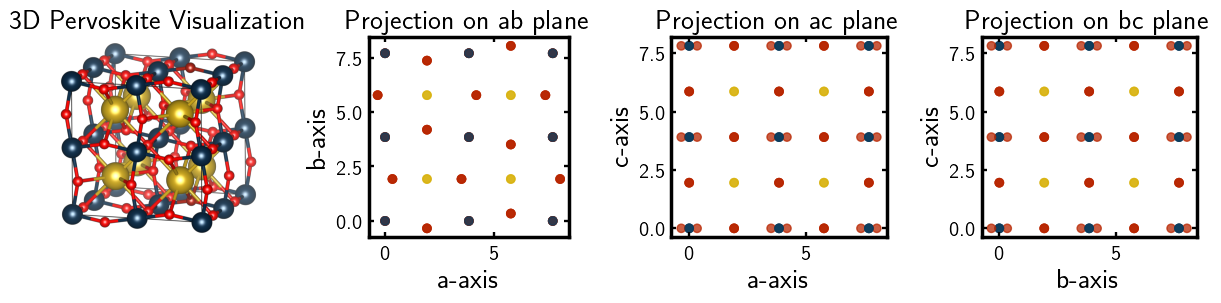

In [5]:
amp = 10
p = perovskites_dict[amp]
#%matplotlib widget
#p.plot_perovskite(plot_3d=True)
p.plot_perovskite(style=bg_mpl_style,
    plot_3d_import='../figs/perovskite/perov_10_3d.png', 
    filename='../figs/perovskite/perov_10.pdf')

# SBM of Rotation, Reflection, Inversion

In [6]:
def midpoint(r):
    return 0.5 * (r[0] + r[1])

def calc_origin(perov, num_supercells):
    perov.expand_by_supercell(num_supercells=num_supercells)
    x_range, y_range, z_range = perov.calc_range(num_supercells=num_supercells)
    origin = [midpoint(x_range), midpoint(y_range), midpoint(z_range)]
    return origin

def calc_variance_sample_size(structure, op, **operator_kwrgs):
    sample_size, _ = structure.calc_symmetry_breaking_measure_sample_size(
        num_samples=NUM_SAMPLES,
        operator=op,
        confidence_interval=CONFIDENCE_LEVEL,
        tolerance_single_side=TOLERANCE_ONE_SIDE,
        method=method,
        **operator_kwrgs
        )
    return sample_size

def compute_sbm(structure, op, **operator_kwrgs):
    sample_size = calc_variance_sample_size(structure, op, **operator_kwrgs)
    measure = structure.calc_symmetry_breaking_measure(
        num_samples=sample_size,
        operator=op,
        method=method,
        **operator_kwrgs
    )
    return measure

def compute_sbm_C4(perov, num_supercells, axis):
    origin = calc_origin(perov, num_supercells)
    rotation_op = RotationOperator(axis=axis, origin=origin)
    measure = 0
    for angle in [90, 180, 270]:
        measure += compute_sbm(perov, rotation_op, angle=angle)
    atoms_info_transformed = perov._calc_atoms_info_transformed(operator=rotation_op, atoms_info=perov._atoms_info, angle=90)
    return measure/3, atoms_info_transformed

def calc_sbm_reflection(perov, num_supercells, axis):
    origin = calc_origin(perov, num_supercells)
    reflection_op = ReflectionOperator(axis=axis, origin=origin)
    measure = compute_sbm(perov, reflection_op)
    atoms_info_transformed = perov._calc_atoms_info_transformed(operator=reflection_op, atoms_info=perov._atoms_info)
    return measure, atoms_info_transformed

def calc_sbm_inversion(perov, num_supercells):
    origin = calc_origin(perov, num_supercells)
    inversion_op = InversionOperator(origin=origin)
    measure = compute_sbm(perov, inversion_op)
    atoms_info_transformed = perov._calc_atoms_info_transformed(operator=inversion_op, atoms_info=perov._atoms_info)
    return measure, atoms_info_transformed

# Paper Section 5.2 - Plots

In [11]:
def sbm_vs_amp(amplitudes:list, num_supercells, op_method, axis=[]):
    measures = []
    for amp in tqdm(amplitudes):
        perov = perovskites_dict[amp]
        if op_method == 'rotation':
            measures.append(compute_sbm_C4(perov, num_supercells, axis)[0])
        if op_method == 'reflection':
            measures.append(calc_sbm_reflection(perov, num_supercells, axis)[0])
        if op_method == 'inversion':
            measures.append(calc_sbm_inversion(perov, num_supercells)[0])
    return measures

def create_line_dict(x, y, linestyle, color):
    return {'x': x, 'y': y, 'linestyle': linestyle, 'color': color}

def plot(data, xlabel, ylabel, xlim, ylim, filename=None, style=None, text=None):
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 4)
    plt.style.use(style)
    rc('text', usetex=True)
    plt.rcParams.update({
        'text.latex.preamble': r'\usepackage{mathrsfs} \usepackage{sansmath} \sansmath'  # Using sansmath package for sans-serif
    })

    for curve in data:
        ax.plot(curve['x'], curve['y'], linestyle=curve['linestyle'], color=curve['color'], linewidth=3.0, alpha=0.8)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel, fontsize=font_size)
    ax.set_ylabel(ylabel, fontsize=font_size)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size) 

    if text:
        ax_text = fig.add_axes(text['loc'])
        ax_text.text(0, 0, text['content'], fontsize=22)
        ax_text.set_axis_off()

    plt.show()
    if filename:
        fig.savefig(filename)

## SBM v.s. Rotation

In [9]:
AMPLITUDES_RANGE = range(MAX_AMPLITUDE+1)
COLORS = {'100': BLUE, '010': RED, '001': YELLOW}
LINESTYLES = {'100': '-', '010': '--', '001': '-.'}

measures = {}
for axis in ['100', '010', '001']:
    axis_list = list(map(int, axis))
    measures[axis] = sbm_vs_amp(AMPLITUDES_RANGE, num_supercells=1, op_method='rotation', axis=axis_list)

data_rotation = [create_line_dict(AMPLITUDES_RANGE, measures[axis], LINESTYLES[axis], COLORS[axis]) for axis in ['100', '010', '001']]

100%|██████████| 21/21 [00:43<00:00,  2.08s/it]


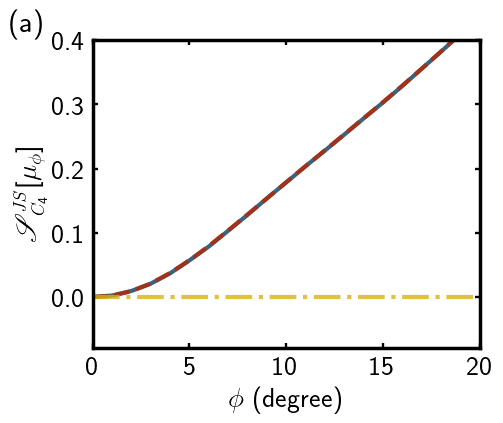

In [13]:
plot(data_rotation, xlabel=r'$\phi$ (degree)', ylabel=r'$\mathscr{S}^{\mathit{JS}}_{\mathit{C}_4}[\mu_{\phi}]$', xlim=[0,20], ylim=[-0.08,.4], 
     filename='../figs/perovskite/SBM_rotation.pdf', 
     style=bg_mpl_style, 
     text={'content':'(a)', 'loc':[-0.04, .9, 0, 0]}, 
)

## SBM v.s. Reflection

In [14]:
AMPLITUDES_RANGE = range(MAX_AMPLITUDE+1)
COLORS = {'100': BLUE, '010': RED, '001': YELLOW}
LINESTYLES = {'100': '-', '010': '--', '001': '-.'}

measures = {}
for axis in ['100', '010', '001']:
    axis_list = list(map(int, axis))
    measures[axis] = sbm_vs_amp(AMPLITUDES_RANGE, num_supercells=1, op_method='reflection', axis=axis_list)

data_reflection = [create_line_dict(AMPLITUDES_RANGE, measures[axis], LINESTYLES[axis], COLORS[axis]) for axis in ['100', '010', '001']]

100%|██████████| 21/21 [00:14<00:00,  1.41it/s]


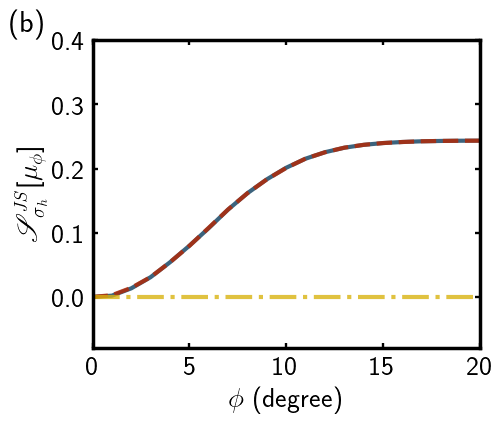

In [16]:
plot(data_reflection, xlabel=r'$\phi$ (degree)', ylabel=r'$\mathscr{S}^{\mathit{JS}}_{\sigma_\mathit{h}}[\mu_{\phi}]$', xlim=[0,20], ylim=[-0.08,.4], 
     filename='../figs/perovskite/SBM_reflection.pdf', 
     style=bg_mpl_style, 
     text={'content':'(b)', 'loc':[-0.04, .9, 0, 0]}, 
)

## SBM v.s. Inversion

In [17]:
AMPLITUDES_RANGE = range(MAX_AMPLITUDE+1)
data_inversion = [{'x': AMPLITUDES_RANGE,
        'y': sbm_vs_amp(AMPLITUDES_RANGE, num_supercells=1, op_method='inversion'), 
        'linestyle': '-.', 
        'color': YELLOW}]

100%|██████████| 21/21 [00:14<00:00,  1.41it/s]


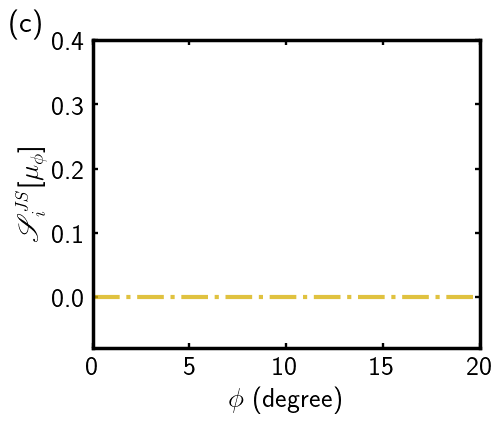

In [18]:
plot(data_inversion, xlabel=r'$\phi$ (degree)', ylabel=r'$\mathscr{S}^{\mathit{JS}}_{\mathit{i}}[\mu_{\phi}]$', xlim=[0,20], ylim=[-0.08,.4], 
     filename='../figs/perovskite/SBM_inversion.pdf', 
     style=bg_mpl_style, 
     text={'content':'(c)', 'loc':[-0.04, .9, 0, 0]}, 
)

## Combined

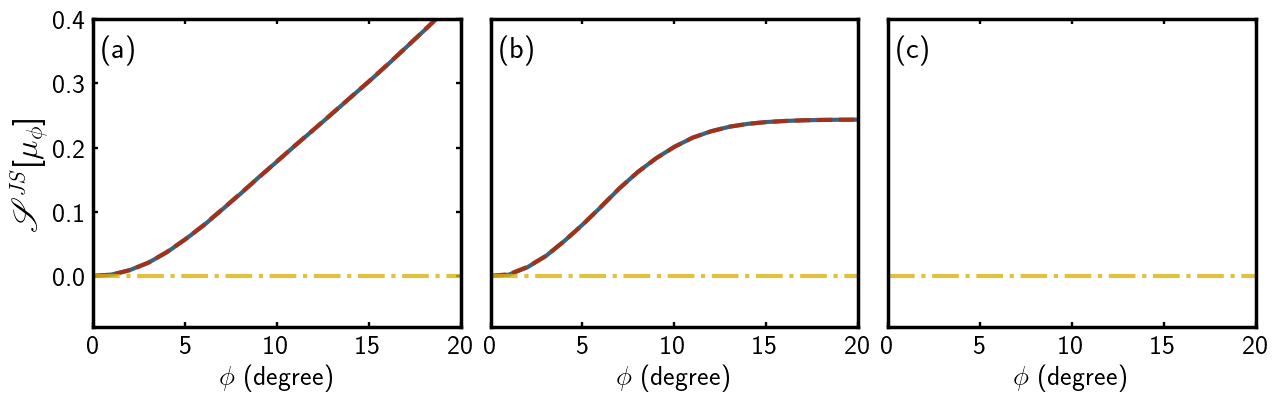

In [24]:
fig, axes = plt.subplots(1, 3)  # Create 3 subplots in 1 row
fig.set_size_inches(15, 4)  # Set the overall figure size

plt.style.use(bg_mpl_style)
rc('text', usetex=True)
plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{mathrsfs} \usepackage{sansmath} \sansmath'  # Using sansmath package for sans-serif
})
data_list = [data_rotation, data_reflection, data_inversion]
text_list = ['(a)', '(b)', '(c)']

xlim = [0, 20]
ylim = [-0.08, 0.4]
xlabel = r'$\phi$ (degree)'
ylabels = r'$\mathscr{S}^{\mathit{JS}}[\mu_{\phi}]$'

for i, ax in enumerate(axes):
    for d in data_list[i]:
        ax.plot(d['x'], d['y'], linestyle=d['linestyle'], color=d['color'], linewidth=3.0, alpha=0.8)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)
    ax.set_xlabel(xlabel, fontsize=font_size)
    ax.text(0.5, 0.34, text_list[i], fontsize=22)
    
axes[0].set_ylabel(ylabels, fontsize=24)
axes[1].set_yticks([])
axes[2].set_yticks([])

plt.subplots_adjust(wspace=0.08)
plt.show()
fig.savefig('../figs/perovskite/SBM_combined.pdf', bbox_inches='tight')